<a href="https://colab.research.google.com/github/vaishnavichoudhari0418/DeepLearningp/blob/main/DL3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset and select BMI feature
diabetes = load_diabetes()
feature_names = diabetes.feature_names
bmi_index = feature_names.index("bmi") if "bmi" in feature_names else 2
X = diabetes.data[:, bmi_index].reshape(-1, 1)   # single feature
y = diabetes.target.reshape(-1, 1)

print("Feature used:", feature_names[bmi_index])
print(pd.DataFrame(np.hstack([X, y]), columns=["bmi", "target"]).head())


Feature used: bmi
        bmi  target
0  0.061696   151.0
1 -0.051474    75.0
2  0.044451   141.0
3 -0.011595   206.0
4 -0.036385   135.0


In [3]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale feature (recommended for GD)
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0, ddof=0)
X_std[X_std == 0] = 1.0

X_train_scaled = (X_train - X_mean) / X_std
X_test_scaled = (X_test - X_mean) / X_std

# Add intercept column
def add_intercept(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

X_train_design = add_intercept(X_train_scaled)
X_test_design = add_intercept(X_test_scaled)


In [4]:
# Cost function
def compute_cost(X_design, y, theta):
    m = X_design.shape[0]
    preds = X_design.dot(theta)
    cost = (1 / (2 * m)) * np.sum((preds - y) ** 2)
    return cost

# Batch Gradient Descent
def batch_gradient_descent(X_design, y, alpha=0.01, num_iters=1000, theta_init=None, verbose=False):
    m, n = X_design.shape
    theta = np.zeros((n, 1)) if theta_init is None else theta_init.copy()
    J_history = []

    for i in range(num_iters):
        preds = X_design.dot(theta)
        error = preds - y
        gradient = (1 / m) * (X_design.T.dot(error))
        theta -= alpha * gradient
        J_history.append(compute_cost(X_design, y, theta))

        if verbose and (i % (num_iters // 5) == 0):
            print(f"Iter {i:04d} | Cost: {J_history[-1]:.6f}")

    return theta, np.array(J_history)


alpha=0.001 | theta(scaled)=[27.88030219  8.54909761] | final cost=10591.625280
alpha=0.010 | theta(scaled)=[133.13897174  40.8251696 ] | final cost=2159.131942
alpha=0.050 | theta(scaled)=[153.73115503  47.13946934] | final cost=1927.056342
alpha=0.100 | theta(scaled)=[153.7365438   47.14112173] | final cost=1927.056326


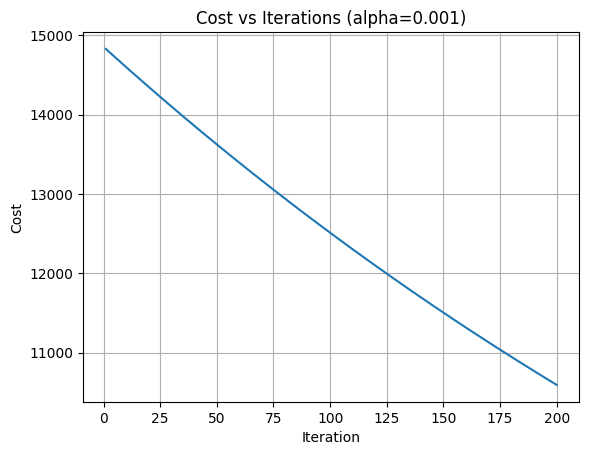

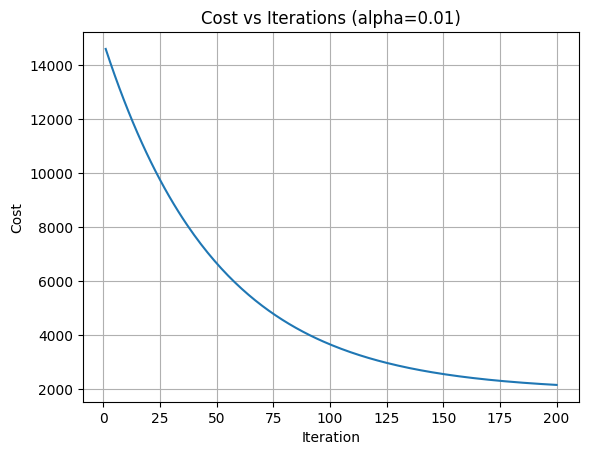

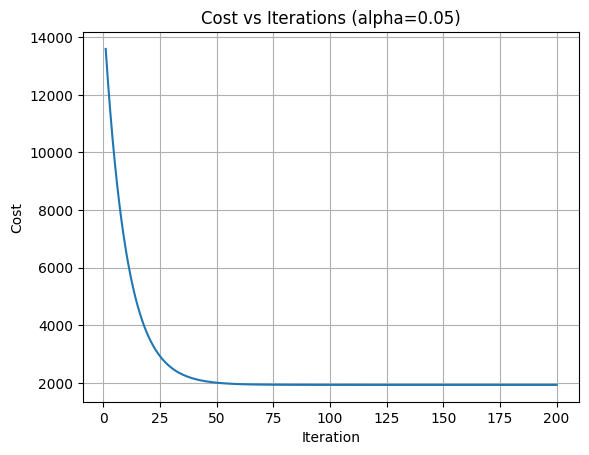

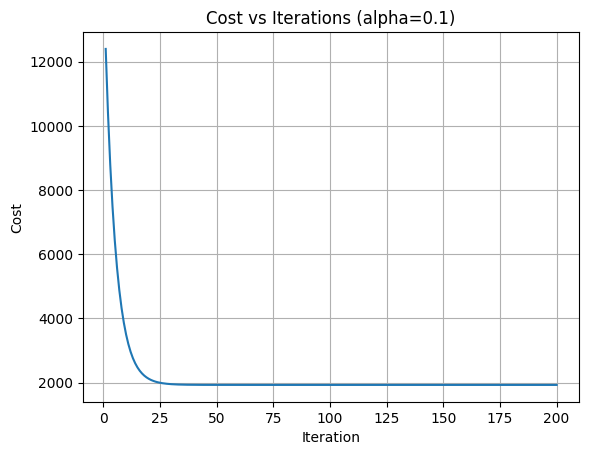

In [5]:
alphas = [0.001, 0.01, 0.05, 0.1]
num_iters_try = 200
gd_results = {}

for alpha in alphas:
    theta, J_hist = batch_gradient_descent(X_train_design, y_train, alpha=alpha, num_iters=num_iters_try)
    gd_results[alpha] = {"theta": theta, "J_hist": J_hist}
    print(f"alpha={alpha:.3f} | theta(scaled)={theta.ravel()} | final cost={J_hist[-1]:.6f}")

# Plot cost vs iterations
for alpha in alphas:
    plt.figure()
    plt.plot(range(1, len(gd_results[alpha]["J_hist"]) + 1), gd_results[alpha]["J_hist"])
    plt.title(f"Cost vs Iterations (alpha={alpha})")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.grid(True)
    plt.show()


GD theta (scaled): [153.73654362  47.14112167]


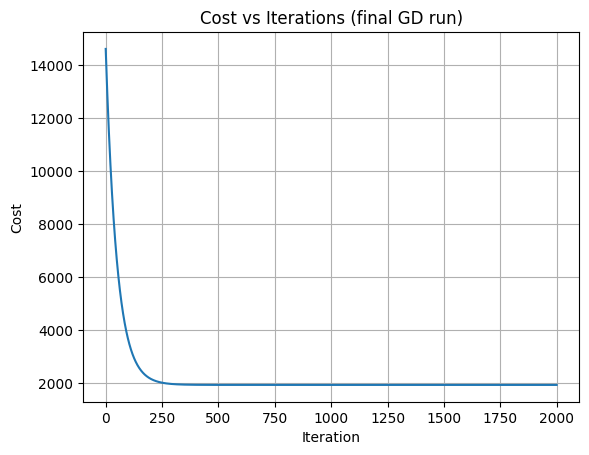

In [6]:
best_alpha = 0.01
num_iters_long = 2000
theta_gd_scaled, J_hist_long = batch_gradient_descent(
    X_train_design, y_train, alpha=best_alpha, num_iters=num_iters_long
)

print("GD theta (scaled):", theta_gd_scaled.ravel())

plt.plot(J_hist_long)
plt.title("Cost vs Iterations (final GD run)")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()


In [7]:
theta0_s, theta1_s = float(theta_gd_scaled[0]), float(theta_gd_scaled[1])
mu, sigma = float(X_mean), float(X_std)

theta1_orig = theta1_s / sigma
theta0_orig = theta0_s - (theta1_s * mu / sigma)
theta_gd_original = np.array([theta0_orig, theta1_orig]).reshape(-1, 1)

print("GD theta (original scale): intercept={:.6f}, slope={:.6f}".format(theta0_orig, theta1_orig))


GD theta (original scale): intercept=152.003354, slope=998.577687


/tmp/ipython-input-633153174.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta0_s, theta1_s = float(theta_gd_scaled[0]), float(theta_gd_scaled[1])
/tmp/ipython-input-633153174.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu, sigma = float(X_mean), float(X_std)


In [8]:
def predict_from_theta_original(theta_original, X_raw):
    return add_intercept(X_raw).dot(theta_original)

y_test_pred_gd = predict_from_theta_original(theta_gd_original, X_test)
mse_gd = mean_squared_error(y_test, y_test_pred_gd)
r2_gd = r2_score(y_test, y_test_pred_gd)

print(f"GD Test MSE: {mse_gd:.4f}, R2: {r2_gd:.4f}")


GD Test MSE: 4061.8259, R2: 0.2334


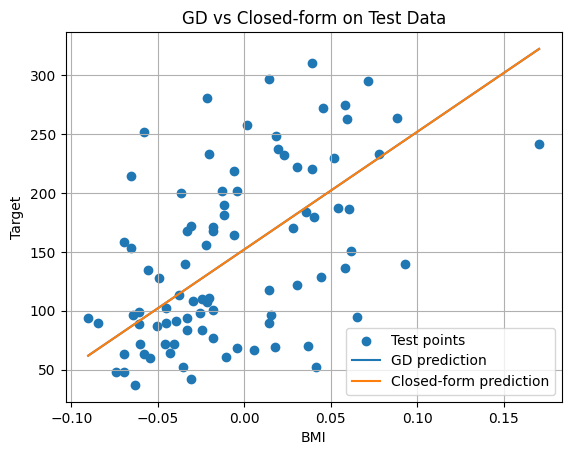

             method   intercept       slope     test_mse  test_r2
0  Gradient Descent  152.003354  998.577687  4061.825927  0.23335
1       Closed-form  152.003354  998.577689  4061.825928  0.23335


In [9]:
# Scatter + prediction lines
plt.scatter(X_test, y_test, label="Test points")
order = np.argsort(X_test.ravel())
Xt_sorted = X_test[order]

plt.plot(Xt_sorted, predict_from_theta_original(theta_gd_original, Xt_sorted), label="GD prediction")
plt.plot(Xt_sorted, predict_from_theta_original(theta_closed, Xt_sorted), label="Closed-form prediction")

plt.xlabel("BMI")
plt.ylabel("Target")
plt.title("GD vs Closed-form on Test Data")
plt.legend()
plt.grid(True)
plt.show()

# Summary
summary = pd.DataFrame({
    "method": ["Gradient Descent", "Closed-form"],
    "intercept": [theta0_orig, theta_closed[0,0]],
    "slope": [theta1_orig, theta_closed[1,0]],
    "test_mse": [mse_gd, mse_closed],
    "test_r2": [r2_gd, r2_closed]
})
print(summary)
